# Unsupervised Planogram Compliance

http://openaccess.thecvf.com/content_ECCV_2018/html/Archan_Ray_U-PC_Unsupervised_Planogram_ECCV_2018_paper.html
http://openaccess.thecvf.com/content_ECCV_2018/papers/Archan_Ray_U-PC_Unsupervised_Planogram_ECCV_2018_paper.pdf

In [125]:
#IMPORTING LIBRARIES

import os
import io
import sys
import numpy as np
from sklearn.cluster import KMeans
import cv2
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

### 1. Hyperparameters 

In [126]:
#KERNEL SIZE
k = 20

#STRIDE
s = 20

#NUMBER OF CLUSTERS 
n_clusters = 3

### 2. Input Rack Image

Shape of rack image: (1060, 3805, 3)


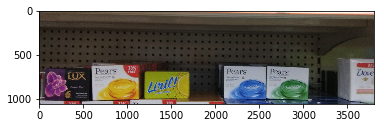

In [127]:
def read_rackImage(image_name):

    img=cv2.imread(image_name)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    X=np.array(img)
    print('Shape of rack image: ' + str(X.shape))
    
    return X, img
    
X, img = read_rackImage('set3_rack.jpeg')

### 3. Pad Rack Image

Shape of padded rack image: (1060, 3820, 3)


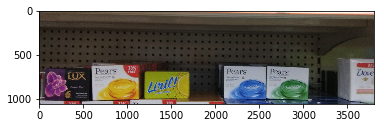

In [128]:
def pad_rackImage(X, img, k):

    h, w = np.shape(X[:,:,-1])
    
    sess = tf.Session()
    with sess.as_default():

        X = tf.pad(X, ([0, (k - h%k)%k], [0, (k - w%k)%k], [0, 0]), name = 'pad_rackImage')
        X = X.eval()
    
    print('Shape of padded rack image: ' + str(np.shape(X)))
    plt.imshow(img)
    
    return X, img

X, img = pad_rackImage(X, img, k)

### 4. Retrive Padded Rack Image Details

In [129]:
def info_rackImage(X, img):
    
    h, w, channels = np.shape(X)
    info = (X, img, h, w, channels)
    
    return info

info = info_rackImage(X, img)

### 5. Sliding Window

In [133]:
def sliding_window(info, k, s):

    X, h, w = info[0], info[2], info[3]
    X1=[]
    
    for i in range(h//k):
        for j in range(w//k):
            
            window = X[i*k:i*k + k, j*k:j*k + k, :]
            X1.append(np.array(window))
    
    #Flatten List of Sliding Windows
    X2np = X1np.reshape(X1np.shape[0], X1np.shape[1]*X1np.shape[2]*X1np.shape[3])
            
    return X1np, X2np

X1np, X2np = sliding_window(info, k, s)
print('Shape of list of sliding window instances: ' + str(X1np.shape) + ' ' + str(X2np.shape))

Shape of list of sliding window instances: (14008, 20, 20, 3) (14008, 1200)


## 6. Implement Kmeans_Cluster

In [136]:
def Kmeans_Cluster(X2np, n_clusters):

    kmeans = KMeans(n_clusters = n_clusters, random_state = 0,verbose = 0).fit_predict(X2np)
    print('Shape of Kmeans output: '+ str(kmeans.shape))
    
    return kmeans

kmeans = Kmeans_Cluster(X2np, n_clusters)

#Instance of Kmeans output
instances = 1000
print('Cluster prediction for '+str(instances)+' windows: ' +str(kmeans[:instances]))

Shape of Kmeans output: (14008,)
Cluster prediction for 1000 windows: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

## 7. Image after Cluster Division

In [135]:
def cluster_rackImage(kmeans, info, n_clusters):

    (_, _, h, w, _) = info
    kmeans1 = kmeans.reshape(h//k, w//k)
    color_map = np.zeros((h, w))

    for i in range(kmeans1.shape[0]):
        for j in range(kmeans1.shape[1]):
            
            col=255/(n_clusters - 1)
            temp = col*kmeans1[i][j] 
            
            color_map[i*k : i*k + k, j*k : j*k + k] = np.full((k,k),temp)
    
    print('Shape of clustered rack image: ' + str(np.shape(color_map)))
        
    return color_map
    
color_map = cluster_rackImage(kmeans, info, n_clusters)
plt.imshow(color_map)
plt.show

ValueError: cannot reshape array of size 14008 into shape (53,191)

#### Notes
1) Changing the following things give different results:
<br/>a) col
<br/>b) n_clusters
<br/>c) kernel_size(k=20 is best till now)